In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from math import sqrt

In [74]:
pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1321 sha256=7283a75e1e009924eb64c7cb4a5b0046f758fd0a6ce130621b56c042b746ae13
  Stored in directory: c:\users\erdem\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [3]:
baslik = ["KullaniciId" , "FilmId" , "Degerlendirme" , "ZamanDamgasi"]
df = pd.read_csv("u.data" , sep = "\t" , names = baslik)
KullanıcıSayısı = df.KullaniciId.unique().shape[0]
FilmSayısı = df.FilmId.unique().shape[0]
print("KullanıcıSayısı =" + str(KullanıcıSayısı) + ", filmsayısı =" + str(FilmSayısı))
df.head()

KullanıcıSayısı =943, filmsayısı =1682


,KullaniciId,FilmId,Degerlendirme,ZamanDamgasi
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


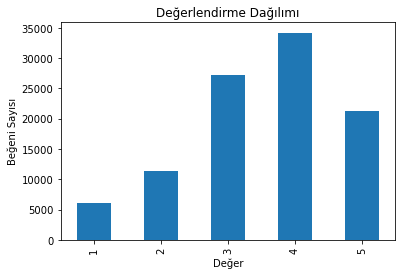

In [18]:
plt.rc("font" , size = 10)
df.Degerlendirme.value_counts(sort = False).plot(kind = "bar")
plt.title("Değerlendirme Dağılımı")
plt.xlabel("Değer")
plt.ylabel("Beğeni Sayısı")
plt.show()

In [ ]:
df_ort = pd.DataFrame(round(df.groupby("FilmId")["Degerlendirme"].mean() , 2))
df_ort["DsTemp"] = pd.DataFrame(df.groupby("FilmId")["Degerlendirme"].count())
df_ort.columns = ["Deger Ortalamasi" , "Deger Sayisi"]
df_ort.sort_values("Deger Sayisi" , ascending = False).head()

In [46]:
k_u_matris = np.zeros((KullanıcıSayısı, FilmSayısı))
for line in df.itertuples():
    k_u_matris[line[1]-1 , line[2]-1] = line[3]
k_u_matris.shape

(943, 1682)

In [47]:
k_u_matris

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [49]:
kullanici_benzerlik = pairwise_distances(k_u_matris , metric = "cosine")
kullanici_benzerlik.shape

(943, 943)

In [50]:
kullanici_benzerlik

array([[0.        , 0.83306902, 0.95254046, ..., 0.85138306, 0.82049212,
        0.60182526],
       [0.83306902, 0.        , 0.88940868, ..., 0.83851522, 0.82773219,
        0.89420212],
       [0.95254046, 0.88940868, 0.        , ..., 0.89875744, 0.86658385,
        0.97344413],
       ...,
       [0.85138306, 0.83851522, 0.89875744, ..., 0.        , 0.8983582 ,
        0.90488042],
       [0.82049212, 0.82773219, 0.86658385, ..., 0.8983582 , 0.        ,
        0.81753534],
       [0.60182526, 0.89420212, 0.97344413, ..., 0.90488042, 0.81753534,
        0.        ]])

In [56]:
def tahmin(degerlendirme , benzerlik):
    ort_deg = degerlendirme.mean(axis = 1)
    deg_fark = (degerlendirme - ort_deg[:,np.newaxis])
    tahmin = ort_deg[: , np.newaxis] + benzerlik.dot(deg_fark) / np.array([np.abs(benzerlik).sum(axis=1)]).T
    return tahmin

In [57]:
kullanici_tahmin = tahmin(k_u_matris , kullanici_benzerlik)

In [60]:
kullanici_tahmin

array([[ 2.06532606,  0.73430275,  0.62992381, ...,  0.39359041,
         0.39304874,  0.3927712 ],
       [ 1.76308836,  0.38404019,  0.19617889, ..., -0.08837789,
        -0.0869183 , -0.08671183],
       [ 1.79590398,  0.32904733,  0.15882885, ..., -0.13699223,
        -0.13496852, -0.13476488],
       ...,
       [ 1.59151513,  0.27526889,  0.10219534, ..., -0.16735162,
        -0.16657451, -0.16641377],
       [ 1.81036267,  0.40479877,  0.27545013, ..., -0.00907358,
        -0.00846587, -0.00804858],
       [ 1.8384313 ,  0.47964837,  0.38496292, ...,  0.14686675,
         0.14629808,  0.14641455]])

In [63]:
seyreklik = round(1.0 - len(df) / float(KullanıcıSayısı * FilmSayısı) , 4)
print("Seyreklik : % " + str(seyreklik*100))

Seyreklik : % 93.7


In [66]:
U, S , Vt = svds(k_u_matris , k = 30)
U.shape

(943, 30)

In [104]:
def RMSE_Hesapla(tahmin , referans_veri):
    tahmin = tahmin[referans_veri.nonzero()].flatten()
    referans_veri = referans_veri[referans_veri.nonzero()].flatten()
    return sqrt(mean_squared_error(tahmin , referans_veri))

In [85]:
#test ve eğitim veri kümesinin ayrıştırılması
egitim_veri_kümesi , test_veri_kümesi = train_test_split(df , test_size = 0.30)

In [88]:
#eğitim matrisinin oluşturulması
k_u_matris_egitim = np.zeros((KullanıcıSayısı , FilmSayısı))
for line in egitim_veri_kümesi.itertuples():
    k_u_matris_egitim[line[1]-1 , line[2]-1] = line[3]

In [86]:
#test matrisinin oluşturulması
k_u_matris_test = np.zeros((KullanıcıSayısı , FilmSayısı))
for line in test_veri_kümesi.itertuples():
    k_u_matris_test[line[1]-1 , line[2]-1] = line[3]

In [89]:
#kullanıcılar arasındaki benzerliklerin hesaplanması
kullanici_benzerlik = pairwise_distances(k_u_matris_egitim , metric = "cosine")

In [90]:
#tahmin fonksiyonun çağrılması
kullanici_tahmin = tahmin(k_u_matris_egitim,kullanici_benzerlik)

In [93]:
print("Orjinal RMSE: " + str(RMSE_Hesapla(kullanici_tahmin,k_u_matris_test)))

Orjinal RMSE: 3.1578375577415105


In [107]:
#SVD Hesaplama
U , S , Vt = svds(k_u_matris_egitim, k = 30)
S_diyag_matris = np.diag(S)
SVD_tahmin = np.dot(np.dot(U , S_diyag_matris) , Vt)
print("SVD RMSE:" + str(RMSE_Hesapla(SVD_tahmin,k_u_matris_test)))

SVD RMSE:2.8664181766509946


In [ ]:
_